In [15]:
# load data and split into train and test sets
import torch
from load_data import sim_arr
from sklearn.model_selection import train_test_split

# reshape from batch, height, width, channel, to batch, channel, height, width
sim_arr_transformed = sim_arr.reshape(
    sim_arr.shape[0], sim_arr.shape[3], sim_arr.shape[1], sim_arr.shape[2])
train_set, test_set = train_test_split(
    sim_arr_transformed, test_size=0.2, random_state=42)

# convert to tensor
train_set = torch.tensor(train_set, dtype=torch.float32)
test_set = torch.tensor(test_set, dtype=torch.float32)

In [17]:
from AE_torch import Autoencoder
from search_space import search_space
import optuna
import warnings


warnings.filterwarnings("ignore")


def objective(trial):
    #clear clutter from previous runs
    torch.cuda.empty_cache()

    # define search space
    num_layers, poolsize, channels, kernel_sizes, dilations, activations = search_space(trial, input_dim=3, output_dim=3)

    # define model
    model = Autoencoder(num_layers=num_layers,
                        poolsize=poolsize,
                        channels=channels,
                        kernel_sizes=kernel_sizes,
                        dilations=dilations,
                        activations=activations,
                        epochs=10,
                        batch_size=32,
                        learning_rate=1e-3,
                        data=train_set)
    
    # train model with k-fold cross validation
    val_losses = model.cross_val()
    val_loss = sum(val_losses) / len(val_losses)
    print("Validation loss:", val_loss)
    return val_loss

# delete the study
#optuna.delete_study(study_name="autoencoder_torch1", storage="sqlite:///autoencoder.db")

# define study
study = optuna.create_study(direction="minimize",
                            pruner=optuna.pruners.HyperbandPruner(),
                            study_name="autoencoder_torch1",
                            storage="sqlite:///autoencoder.db",
                            load_if_exists=True)

study.optimize(objective, n_trials=0)

# Get the best hyperparameters
best_params = study.best_params
print("Best hyperparameters:", str(best_params))
print("Best value:", study.best_value)


[I 2024-05-08 11:32:09,148] Using an existing study with name 'autoencoder_torch1' instead of creating a new one.


Best hyperparameters: {'num_layers': 3, 'poolsize_3': [2, 20, 2], 'channels_0': 9, 'channels_1': 10, 'kernel_size_0': 8, 'kernel_size_1': 20, 'kernel_size_2': 5, 'dilation_0': 1, 'dilation_1': 2, 'dilation_2': 3, 'activation_0': 'nn.Tanh', 'activation_1': 'nn.SiLU', 'activation_2': 'nn.Tanh'}
Best value: 0.02036499066546983


In [ ]:
# train model with best hyperparameters
num_layers, poolsize, channels, kernel_sizes, dilations, activations = search_space(
    study.best_trial, input_dim=3, output_dim=3)

model = Autoencoder(num_layers=num_layers,
                    poolsize=poolsize,
                    channels=channels,
                    kernel_sizes=kernel_sizes,
                    dilations=dilations,
                    activations=activations,
                    epochs=10,
                    batch_size=32, 
                    learning_rate=1e-3,
                    data=train_set)

model.cross_val()


Fold 1/5


Epoch 1/10 Loss: 6.0026
Epoch 2/10 Loss: 3.1614
Epoch 3/10 Loss: 3.6405
Epoch 4/10 Loss: 2.8993
Epoch 5/10 Loss: 2.2962
Epoch 6/10 Loss: 2.0475
Epoch 7/10 Loss: 1.9519
Epoch 8/10 Loss: 1.7819
Epoch 9/10 Loss: 1.6652
Epoch 10/10 Loss: 1.6888
Validation Loss: 1.5224
Fold 2/5
Epoch 1/10 Loss: 1.5515
Epoch 2/10 Loss: 1.4495
Epoch 3/10 Loss: 1.4191
Epoch 4/10 Loss: 1.4456
Epoch 5/10 Loss: 1.4779
Epoch 6/10 Loss: 1.5820
Epoch 7/10 Loss: 1.5400
Epoch 8/10 Loss: 1.4458
Epoch 9/10 Loss: 1.6292
Epoch 10/10 Loss: 2.7729
Validation Loss: 2.4502
Fold 3/5
Epoch 1/10 Loss: 2.0168
Epoch 2/10 Loss: 1.5625
Epoch 3/10 Loss: 1.4426
Epoch 4/10 Loss: 1.4008
Epoch 5/10 Loss: 1.4890
Epoch 6/10 Loss: 1.4885
Epoch 7/10 Loss: 1.6467
Epoch 8/10 Loss: 1.4441
Epoch 9/10 Loss: 1.5174
Epoch 10/10 Loss: 1.3418
Validation Loss: 1.2819
Fold 4/5
Epoch 1/10 Loss: 1.2935
Epoch 2/10 Loss: 1.1824
Epoch 3/10 Loss: 1.0689
Epoch 4/10 Loss: 1.0454
Epoch 5/10 Loss: 1.0401
Epoch 6/10 Loss: 0.9791
Epoch 7/10 Loss: 0.9477
Epoch 8/10

[1.5223677214235067,
 2.450192484539002,
 1.2819065293297172,
 0.8399821053026244,
 0.7217357301851735]

In [21]:
# summarize the model
print(model)


Autoencoder(
  (encoder): Encoder(
    (layers): ModuleList(
      (0): Conv2dSame(3, 9, kernel_size=(8, 8), stride=(1, 1))
      (1): Tanh()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
      (3): Conv2dSame(9, 10, kernel_size=(20, 20), stride=(1, 1), dilation=(2, 2))
      (4): SiLU()
      (5): MaxPool2d(kernel_size=20, stride=20, padding=0, dilation=1, ceil_mode=True)
      (6): Conv2dSame(10, 3, kernel_size=(5, 5), stride=(1, 1), dilation=(3, 3))
      (7): Tanh()
      (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
    )
  )
  (decoder): Decoder(
    (layers): ModuleList(
      (0): MaxUnpool2d(kernel_size=(2, 2), stride=(2, 2), padding=(0, 0))
      (1): Tanh()
      (2): Conv2dSame(3, 10, kernel_size=(5, 5), stride=(1, 1), dilation=(3, 3))
      (3): MaxUnpool2d(kernel_size=(20, 20), stride=(20, 20), padding=(0, 0))
      (4): SiLU()
      (5): Conv2dSame(10, 9, kernel_size=(20, 20), stride=(1, 1), dilation

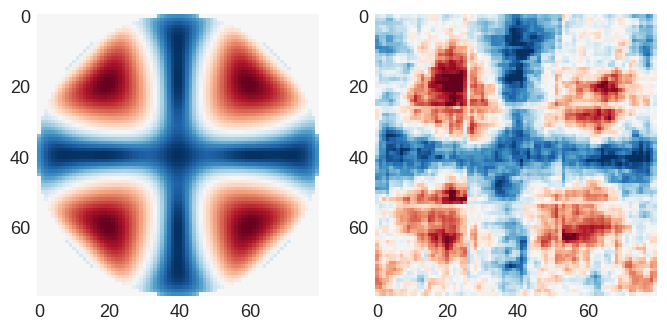

In [22]:
import numpy as np
import matplotlib.pyplot as plt

i = np.random.randint(0, len(test_set))
in_sim = test_set[i: i + 1]
in_sim = in_sim.to('cuda:0')
out_sim = model(in_sim)
in_sim = in_sim.detach().to('cpu').numpy()
in_sim = in_sim.reshape(in_sim.shape[0], in_sim.shape[2], in_sim.shape[3], in_sim.shape[1])
out_sim = out_sim.detach().to('cpu').numpy()
out_sim = out_sim.reshape(out_sim.shape[0], out_sim.shape[2], out_sim.shape[3], out_sim.shape[1])
fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].imshow(in_sim[0, ..., 2], vmin=-1, vmax=1, cmap="RdBu")
ax[1].imshow(out_sim[0, ..., 2], vmin=-1, vmax=1, cmap="RdBu")

In [23]:
import matplotlib.pyplot as plt

# plot val_losses and losses against epochs
plt.figure()
plt.plot(history.history['loss'])
plt.plot(model.val_losses)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

AttributeError: 'Autoencoder' object has no attribute 'losses'

<Figure size 800x600 with 0 Axes>

In [29]:
from clustering import DBSCANLayer
from sklearn.model_selection import KFold


cluster = DBSCANLayer(eps=0.5, min_samples=10)

class JointAutoencoder(torch.nn.Module):
    def __init__(self, encoder, decoder):
        super(JointAutoencoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.cluster = cluster
        self.epochs = 10
        self.batch_size = 32
        self.data = train_set

    def forward(self, x):
        x = self.encoder(x)
        clusters = self.cluster(x)
        x = self.decoder(x)
        
        return x, clusters
    
    def _get_loss(self, x, x_hat, clusters):
        reconstruction_loss = torch.nn.functional.mse_loss(x_hat, x, reduction='mean')
        cluster_loss = torch.nn.functional.kl_div(clusters, torch.ones_like(clusters), reduction='mean')
        return reconstruction_loss + cluster_loss

    
    def train_model(self, dataloader, device=torch.device('cuda:0')):
        """Train the autoencoder."""
        self.to(device)
        self.train()
        for epoch in range(self.epochs):
            running_loss = 0.0
            for batch in dataloader:
                batch = batch.to(device)
                self.optimizer.zero_grad()
                loss = self._get_loss(batch)
                loss.backward()
                self.optimizer.step()
                running_loss += loss.item() * batch.size(0)
            epoch_loss = running_loss / len(dataloader)
            print(f"Epoch {epoch+1}/{self.epochs} Loss: {epoch_loss:.4f}")

    def evaluate_model(self, dataloader, device=torch.device('cuda:0')):
        """Evaluate the autoencoder."""
        self.to(device)
        self.eval()
        total_loss = 0.0
        with torch.no_grad():
            for batch in dataloader:
                batch = batch.to(device)
                loss = self._get_loss(batch)
                total_loss += loss.item() * batch.size(0)
        avg_loss = total_loss / len(dataloader)
        print(f"Validation Loss: {avg_loss:.4f}")
        return avg_loss

    def cross_val(self, n_splits=5):
        """Perform cross-validation on the autoencoder."""
        torch.backends.cudnn.benchmark = True
        kf = KFold(n_splits=n_splits, shuffle=True)
        val_losses = []
        for fold, (train_index, val_index) in enumerate(kf.split(self.data)):
            print(f"Fold {fold+1}/{n_splits}")
            train_sampler = torch.utils.data.SubsetRandomSampler(train_index)
            val_sampler = torch.utils.data.SubsetRandomSampler(val_index)

            train_loader = torch.utils.data.DataLoader(
                self.data,
                sampler=train_sampler,
                batch_size=self.batch_size,
                num_workers=12)
            val_loader = torch.utils.data.DataLoader(
                self.data,
                sampler=val_sampler,
                batch_size=self.batch_size,
                num_workers=12)

            self.train_model(train_loader)
            val_loss = self.evaluate_model(val_loader)
            val_losses.append(val_loss)
        return val_losses
    
joint_autoencoder = JointAutoencoder(encoder=model.encoder, decoder=model.decoder)
joint_autoencoder.cross_val()


AttributeError: 'JointAutoencoder' object has no attribute 'data'